In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import argparse

## Define the Super parameter

In [2]:
# initialise the parameters of the LeNet model
EPOCH = 8   #遍历数据集次数
BATCH_SIZE = 64      #批处理尺寸(batch_size)
LR = 0.001        #学习率

## Get the trainset
Use the torchvision package to get the minist dataset. From the package getting the train set. 

In [3]:
# Get trainset from the torchvision
# define the method of preprocessing the data.
transform = transforms.ToTensor()

trainset = tv.datasets.MNIST(
    root='./data/',
    train = True,
    download = True,
    transform = transform)
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()

## Get the Testset
Use the torchvision package to get the minist dataset. From the package getting the test set.

In [4]:
# define the batch processing data of the train data
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    )

In [14]:
# define test set
testset = tv.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)
testset[1][0].size()

torch.Size([1, 28, 28])

In [7]:
# define the batch processing dataset
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    )

In [28]:
# show the function of the dataloader, we can understand that  every batch return the inputs and the labels. 
# The size of inputs is [64, 1, 28, 28], that means we have 64 samples, every sample is a figure, and it is [1 , 28 , 28].
# In the meanwhile, we get the labels that are a 1 demension tensor including 64 elements.
for data in testloader:
    images , labels = data
    print("the images are: " , images.size())
    print("the labels are: " , labels.size())
    break

the images are:  torch.Size([64, 1, 28, 28])
the labels are:  torch.Size([64])


## Define the model
Define the LeNet model based on package nn.Module()
the model is like belowing:
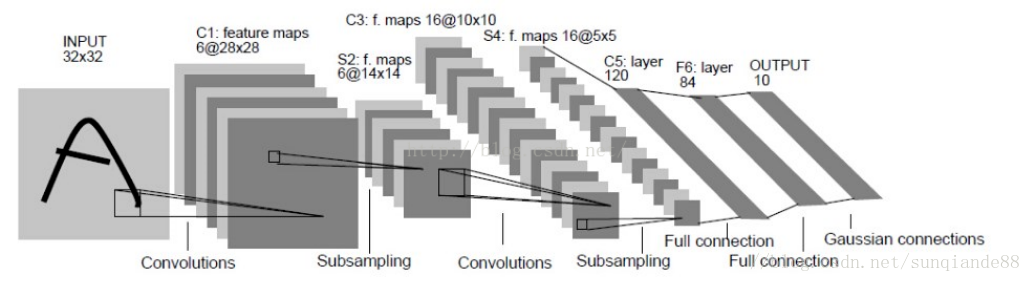

In [22]:
# define the LeNet model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet , self).__init__()
        # define the parameter of the first convelution layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1 , out_channels = 6 , kernel_size = 5 , stride = 1 , padding = 2),  # padding = 2 can make the conv operator don't reduce the size of figure
            nn.ReLU(),  # Rectified Linear Unit, ReLU  #input_size=(6*28*28)
            nn.MaxPool2d(kernel_size=2, stride=2),#output_size=(6*14*14)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 6 , out_channels = 16 , kernel_size = 5 , stride = 1) ,
            nn.ReLU(),  #input_size=(16*10*10)
            nn.MaxPool2d(kernel_size = 2 , stride = 2),  #output_size=(16*5*5)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(16 * 5 * 5 , 120),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(120 , 84) , 
            nn.ReLU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(84 , 10) , 
        )
    
    def forward(self , x):
        # Define forward propagation process, the input is x.
        x = self.conv1(x)
        x = self.conv2(x)
        # the input and output of nn.Linear()are both 1 dimension, so we have to change the input's dimension
        x = x.view(x.size()[0] , -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Define the loss function and optimization
define the loss function, here we use crossEntropyLoss function. and we use SGD to optimize the model

In [23]:
# 定义损失函数loss function 和优化方式（采用SGD）
net = LeNet()
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数，通常用于多分类问题上
optimizer = optim.SGD(net.parameters(), lr = LR, momentum = 0.9)

## Train the model, and test the model
train the model based on the predefined transet , testset , LeNet ,SGD , loss function. 

Then get the accurancy every epoch, meanwhile print it.

Finally, save the parameters of the model every epoch.

In [42]:
for epoch in range(EPOCH):
    sum_loss = 0.0
    net.train()  #  set the net as the train mode, which means the batch layer's parameters are stable and drop out is unworking!  
    # get the data
    for i  , data in enumerate(trainloader):
        inputs , labels = data  # get the input of the data and the target of the data
#         inputs , labels = inputs.to(device) , labels.to(device) 
        
        # Gradient clearing
        optimizer.zero_grad()
        
        # forward and backward
        outputs = net(inputs)  # forward
        loss = criterion(outputs , labels)  # use the predefined loss function to calculate the loss value
        loss.backward()  # backward propagation, prepare to update the parameters
        optimizer.step()  # update the parameters of the model.
        
        # print the loss value every 100 batches.
        sum_loss += loss.item()  #get the value from the tensor, and add it to the sum_loss
        if i % 100 == 99:  # need to print the value 
            print("epoch {0}, {1}th batches, the sum_loss is {2} .".format((epoch+1) , (i + 1) , sum_loss / 100))
            sum_loss = 0.0
    
    net.eval()  # set the model as the test mode.
    # if one epoch has been over, then test the accuaccy, and print it.
    with torch.no_grad(): # do not need calculate the gradient
        correct = 0.0
        total = 0.0
        for data in testloader:
            images , labels = data
#             images , labels = images.to(device) , labels.to(device)
            outputs = net(images)
            # set the input as the label that get the highest score
            _ , predicted = torch.max(outputs.data , 1)  # return the max value of one row and the index of the max value
            total = total + labels.size(0)
            correct += (predicted == labels).sum()
        print("The accurancy of {}th epoch is : {:.3f}%".format(epoch + 1 , correct / total * 100))
    # save the parameters of the model.
    state_paras ={'net':net.state_dict(), 'optimizer':optimizer.state_dict(), 'epoch' : epoch} 
    torch.save(state_paras , "./stateparas/{0}epoch_model_para.pth".format(epoch))

epoch 1, 100th batches, the sum_loss is 0.08244874673429876 .
epoch 1, 200th batches, the sum_loss is 0.07753919678740204 .
epoch 1, 300th batches, the sum_loss is 0.0779292999766767 .
epoch 1, 400th batches, the sum_loss is 0.06155304884538054 .
epoch 1, 500th batches, the sum_loss is 0.07974136198870838 .
epoch 1, 600th batches, the sum_loss is 0.07244771219789982 .
epoch 1, 700th batches, the sum_loss is 0.0808509372593835 .
epoch 1, 800th batches, the sum_loss is 0.07337676984257996 .
epoch 1, 900th batches, the sum_loss is 0.08023160063661634 .
The accurancy of 1th epoch is : 97.680%
epoch 2, 100th batches, the sum_loss is 0.0693113488610834 .
epoch 2, 200th batches, the sum_loss is 0.06101552820764482 .
epoch 2, 300th batches, the sum_loss is 0.06972688414156437 .
epoch 2, 400th batches, the sum_loss is 0.06563607755117118 .
epoch 2, 500th batches, the sum_loss is 0.07597090432420373 .
epoch 2, 600th batches, the sum_loss is 0.06872495871968567 .
epoch 2, 700th batches, the sum_l

## load model from the saved parameters, and test the pre-saving model

**get a testset data, and see the data**

In [43]:
# get a test batch set firstly.
for data in testloader:
    images , labels = data
    break
print("images: " , images.size())
print("labels:" , labels.size())

images:  torch.Size([64, 1, 28, 28])
labels: torch.Size([64])


**load data from the pre-saving parameters**

In [44]:
# load model based on the parameters that saved before.
directory_para = "./stateparas/7epoch_model_para.pth"
checkpoint = torch.load(directory_para)
net.load_state_dict(checkpoint['net'])  # get the after training model
optimizer.load_state_dict(checkpoint['optimizer'])  # get the optimizer parameters

**test the model**
this cell is to find mistakes in the model, because the accurancy is always 0.
Finally , i find the mistake is that i set the variable 'correct' and 'total' as int.

In [45]:
total = 0.0
correct = 0.0
outputs = net(images)
_ , predicted = torch.max(outputs.data , 1)  # return the max value of one row and the index of the max value
# print((predicted == labels).sum())
total = total + labels.size(0)
correct += (predicted == labels).sum()
print(correct , total)
print(correct / total)

tensor(64.) 64.0
tensor(1.)
